# **FINANCIAL NEWS SENTIMENT ANALYSIS**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import scipy.sparse
ps = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
import joblib

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv("all-data.csv", encoding='latin1')
df.head()

,Sentiment,News_statement
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
df.shape

(4846, 2)

### DROPPING DUPLICATES

In [4]:
df.duplicated().sum()

np.int64(6)

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

### BASIC INFORMATION ABOUT DATA / DATA PREPROCESSING

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4840 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sentiment       4840 non-null   object
 1   News_statement  4840 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


In [7]:
df.isna().sum()

,0
Sentiment,0
News_statement,0


In [8]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,2873
positive,1363
negative,604


The data is imbalanced with a higher number of neutral instances compared to positive and negative ones. We will take care of this.

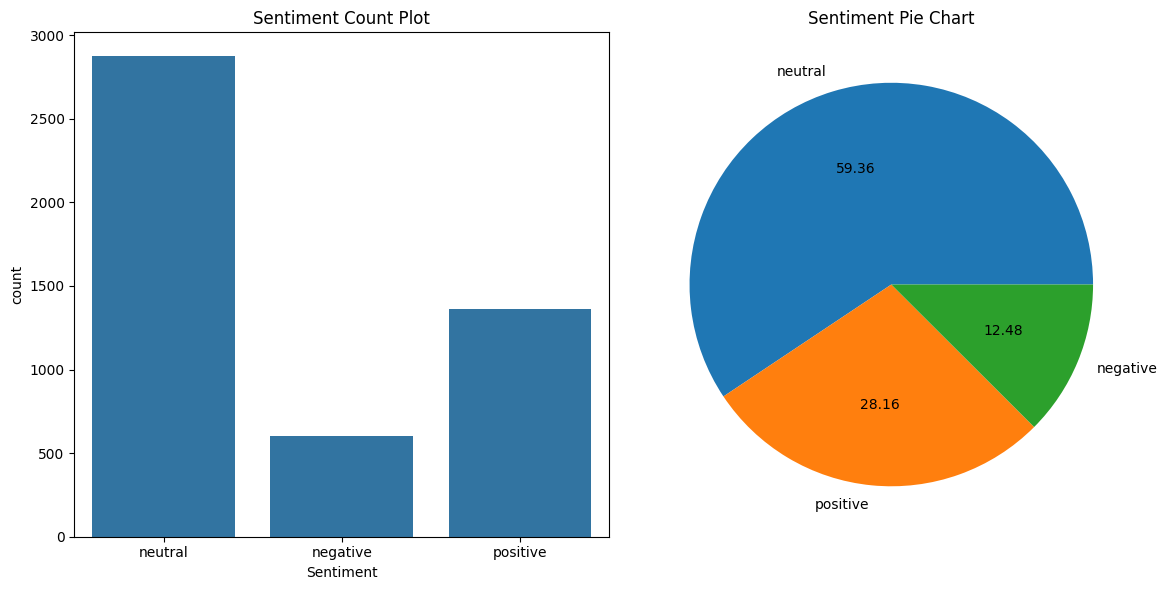

In [9]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the count plot on the first subplot
sns.countplot(x=df['Sentiment'], ax=ax[0])
ax[0].set_title('Sentiment Count Plot')

# Plot the pie chart on the second subplot
sentiment_counts = df['Sentiment'].value_counts()
ax[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct="%0.2f")
ax[1].set_title('Sentiment Pie Chart')

# Show the plots
plt.tight_layout()
plt.show()

- The dataset has more instances of neutral sentiment than positive or negative sentiments, with positive instances outnumbering negative ones. This distribution could impact the analysis and modeling steps, particularly in terms of handling class imbalance, which might necessitate techniques like resampling or adjusting class weights during model training.

### ENCODING OF TARGET VARIABLE

In [10]:
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])
df

,Sentiment,News_statement
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


## EDA

#### (A) NUMBER OF CHARACTERS

In [11]:
df['num_characters'] = df['News_statement'].apply(len)
df.head()

,Sentiment,News_statement,num_characters
0,1,"According to Gran , the company has no plans t...",127
1,1,Technopolis plans to develop in stages an area...,190
2,0,The international electronic industry company ...,228
3,2,With the new production plant the company woul...,206
4,2,According to the company 's updated strategy f...,203


<Axes: xlabel='num_characters', ylabel='Count'>

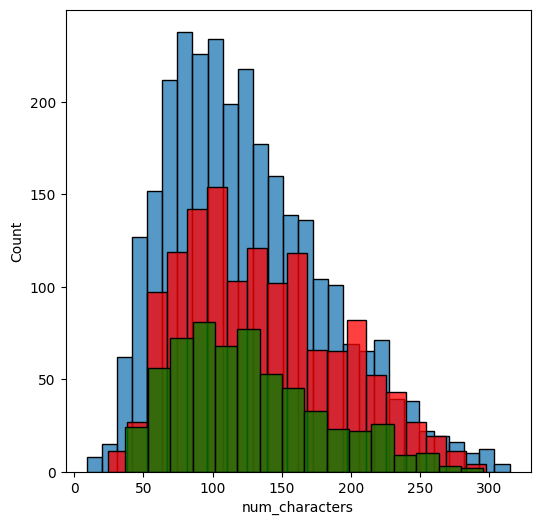

In [12]:
plt.figure(figsize=(6,6))
sns.histplot(df[df['Sentiment'] == 1]['num_characters'])
sns.histplot(df[df['Sentiment'] == 2]['num_characters'],color='red')
sns.histplot(df[df['Sentiment'] == 0]['num_characters'],color='green')

- The majority of texts are concentrated between 50 to 150 characters. Neutral texts (blue) are the most frequent, followed by positive texts (red), and then negative texts (green). As the number of characters increases, the frequency of texts decreases for all sentiments.










#### (B) NUMBER OF WORDS

In [13]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [14]:
df['num_words'] = df['News_statement'].apply(lambda x: len(nltk.word_tokenize(str(x))))
df.head()


,Sentiment,News_statement,num_characters,num_words
0,1,"According to Gran , the company has no plans t...",127,25
1,1,Technopolis plans to develop in stages an area...,190,31
2,0,The international electronic industry company ...,228,36
3,2,With the new production plant the company woul...,206,33
4,2,According to the company 's updated strategy f...,203,41


<Axes: xlabel='num_words', ylabel='Count'>

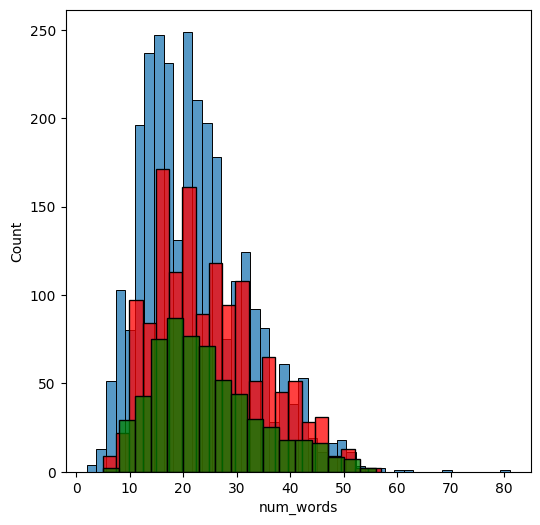

In [15]:
plt.figure(figsize=(6,6))
sns.histplot(df[df['Sentiment'] == 1]['num_words'])
sns.histplot(df[df['Sentiment'] == 2]['num_words'],color='red')
sns.histplot(df[df['Sentiment'] == 0]['num_words'],color='green')

#### (C) NUMBER OF SENTENCES

In [16]:
df['num_sentences'] = df['News_statement'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,Sentiment,News_statement,num_characters,num_words,num_sentences
0,1,"According to Gran , the company has no plans t...",127,25,1
1,1,Technopolis plans to develop in stages an area...,190,31,1
2,0,The international electronic industry company ...,228,36,1
3,2,With the new production plant the company woul...,206,33,1
4,2,According to the company 's updated strategy f...,203,41,1


In [17]:
df['num_sentences'].value_counts()

,count
num_sentences,
1,4786
2,51
3,3


### Description

In [18]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4840.000000,4840.000000,4840.000000
mean,128.076446,23.139669,1.011777
std,56.416479,9.987071,0.113492
min,9.000000,2.000000,1.000000
25%,84.000000,16.000000,1.000000
50%,119.000000,21.000000,1.000000
75%,163.000000,29.000000,1.000000
max,315.000000,81.000000,3.000000


The dataset consists of 4,840 text samples. On average, each text contains approximately 128 characters, 23 words, and 1 sentence. The variability is moderate, with a standard deviation of about 56 characters and 10 words, while the number of sentences has low variability. The shortest text has 9 characters, 2 words, and 1 sentence, whereas the longest text reaches 315 characters, 81 words, and 3 sentences. The interquartile range indicates that 50% of the texts fall between 84 and 163 characters and 16 to 29 words, with most texts being single sentences.

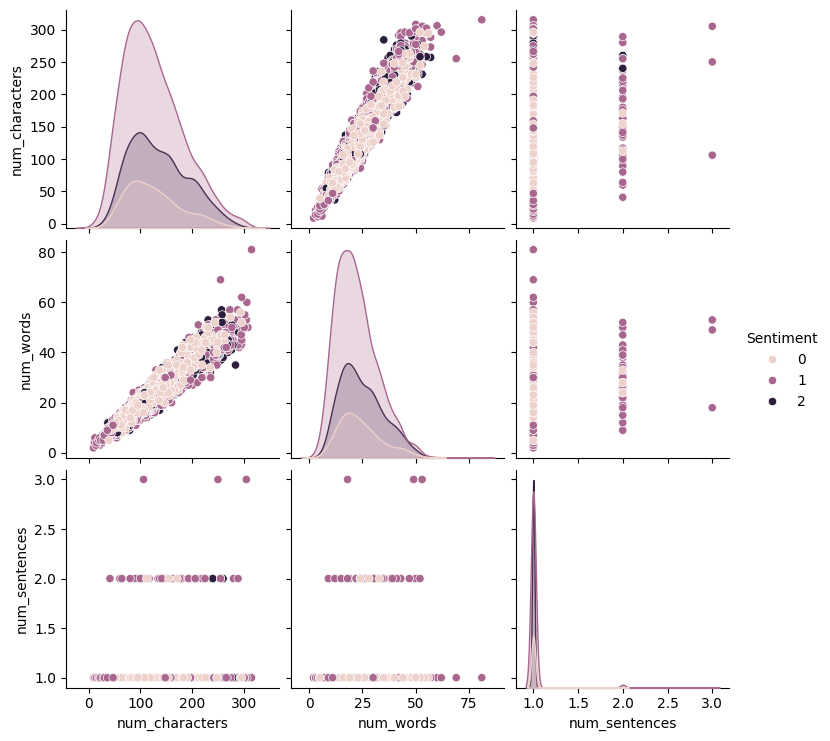

In [ ]:
sns.pairplot(df,hue='Sentiment')

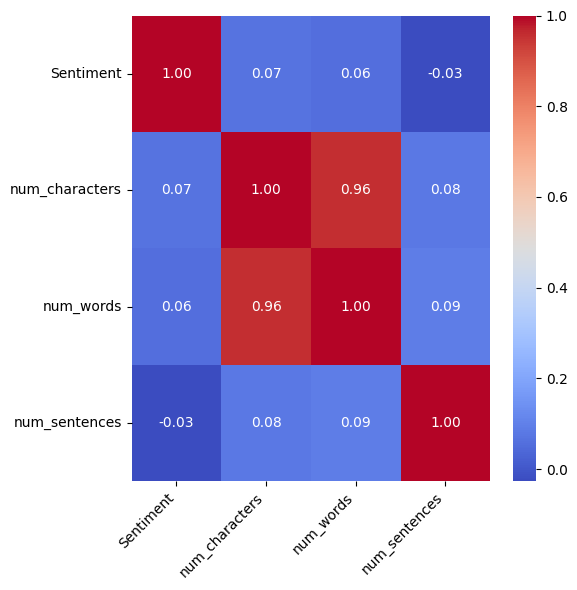

In [19]:
numeric_df = df.select_dtypes(include=['number'])

# Set the figure size to make the heatmap more readable
plt.figure(figsize=(6, 6))

# Plot the heatmap with correlation matrix
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})

# Adjust the heatmap to ensure labels don't overlap
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the heatmap
plt.tight_layout()
plt.show()

# Data Preprocessing
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [20]:
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))-set(["not"])

def transform_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(token) for token in tokens
        if token.isalnum() and token not in stop_words
    ]
    return " ".join(cleaned_tokens)

df['News_statement'] = df['News_statement'].apply(transform_text)
df['News_statement']

,News_statement
0,according gran company plan move production ru...
1,technopolis plan develop stage area less squar...
2,international electronic industry company elco...
3,new production plant company would increase ca...
4,according company updated strategy year baswar...
...,...
4841,london marketwatch share price ended lower lon...
4842,rinkuskiai beer sale fell per cent million lit...
4843,operating profit fell eur mn eur mn 2007 inclu...
4844,net sale paper segment decreased eur mn second...


# TEXT POLARITY

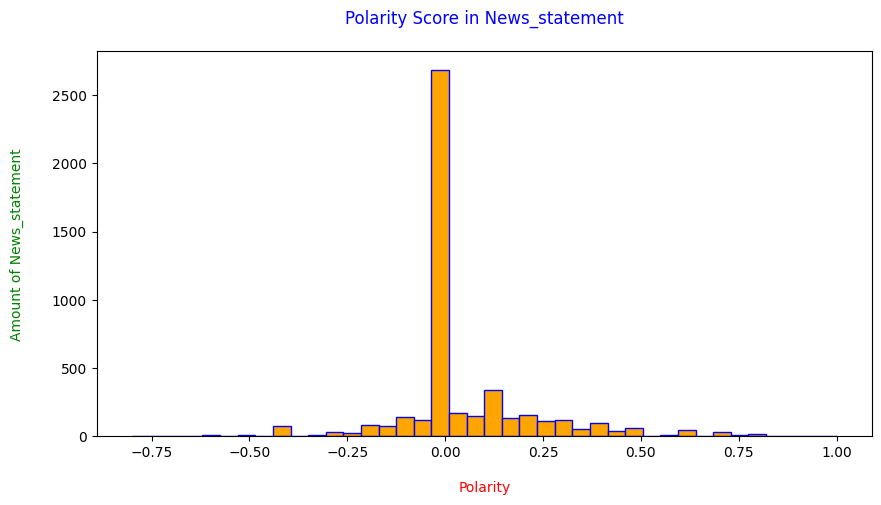

In [21]:
df["polarity"] = df["News_statement"].map(lambda Text: TextBlob(Text).sentiment.polarity)

df["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in News_statement", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of News_statement", labelpad = 20, color = "green")

plt.show()

The histogram presents the distribution of polarity scores in news statements, indicating the sentiment associated with each statement. Here's a summary:

- **Neutral Dominance**: The vast majority of news statements have a polarity score around 0, reflecting a neutral sentiment.
- **Skewed Distribution**: There are fewer statements with positive (greater than 0) or negative (less than 0) polarity scores, highlighting a significant imbalance in sentiment distribution.
- **Low Extremes**: Very few statements exhibit extreme positive or negative sentiments, as shown by the low frequencies at the ends of the polarity scale.
- **Implications for Analysis**: The pronounced peak at the neutral score suggests that special attention is needed to address this imbalance for effective sentiment analysis and model training.

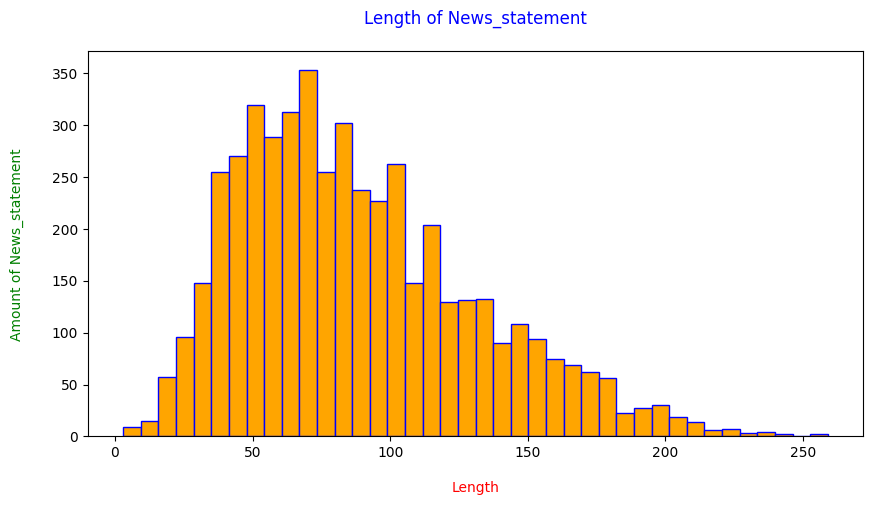

In [22]:
df["length"] = df["News_statement"].astype(str).apply(len)
df["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Length of News_statement", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Amount of News_statement", labelpad = 20, color = "green")

plt.show()

The histogram shows the distribution of the lengths of news statements. Here’s a summary interpretation:

- **Length Distribution**: The lengths of news statements vary, with most statements falling between 20 and 100 characters.
- **Peak Range**: The highest frequency of news statements is around 50-60 characters in length.
- **Skewness**: The distribution is right-skewed, with a longer tail extending towards the higher lengths, indicating fewer statements with lengths greater than 100 characters.
- **Maximum Length**: Very few news statements exceed 150 characters, and almost none go beyond 200 characters.
- **Implications**: This distribution can help in preprocessing steps like padding or truncating sequences to a standard length for model training and can inform the selection of appropriate sequence lengths for NLP tasks.

# Word Counts

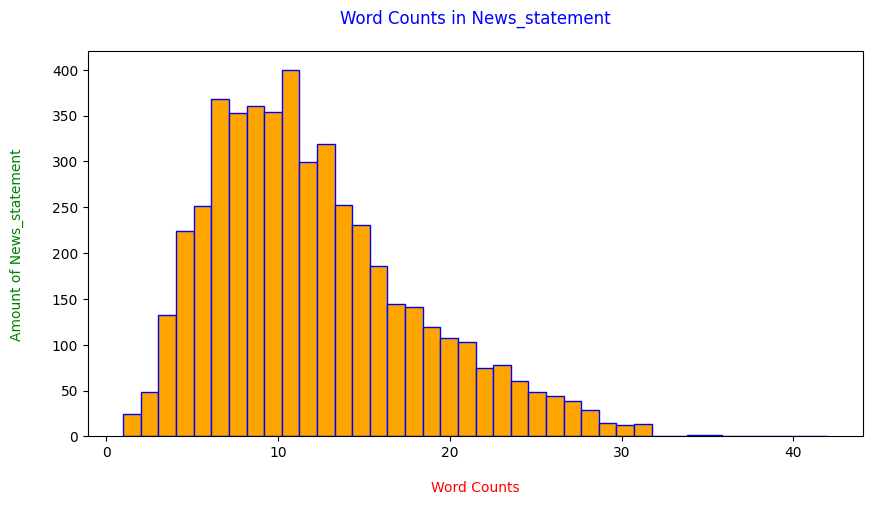

In [23]:
df["word_counts"] = df["News_statement"].apply(lambda x: len(str(x).split()))
df["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in News_statement", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of News_statement", labelpad = 20, color = "green")

plt.show()

# N-Gram Analysis

N-Gram Function

In [24]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = list(Stopwords), ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

##### Filter The DataFrame Based On Sentiments

In [25]:
# Use dropna() so the base DataFrame is not affected
Positive = df[df["Sentiment"] == 2]
Neutral = df[df["Sentiment"] == 1]
Negative = df[df["Sentiment"] == 0]

##### Unigram of Reviews Based on Sentiments

Text(0, 0.5, 'Top Words')

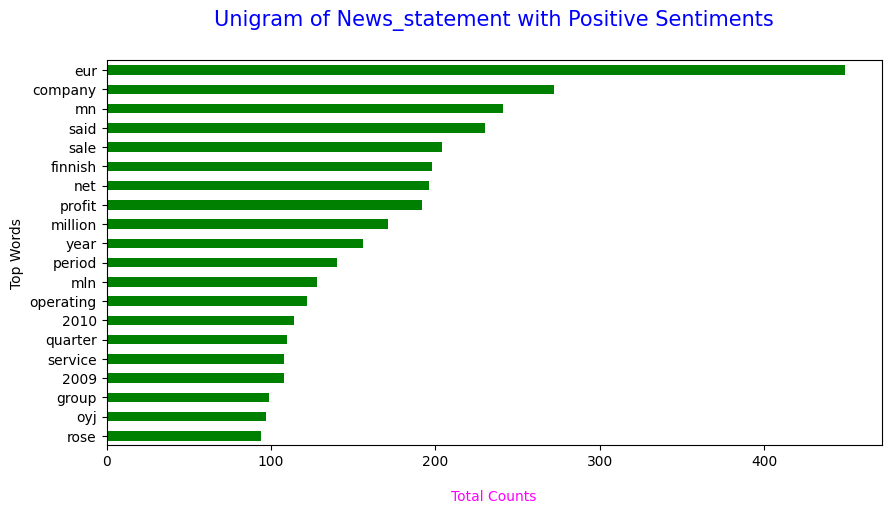

In [26]:
 #Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

# Finding Unigram
words = Gram_Analysis(Positive["News_statement"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green", figsize=(10, 5))
plt.title("Unigram of News_statement with Positive Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words")

Text(0, 0.5, 'Top Words')

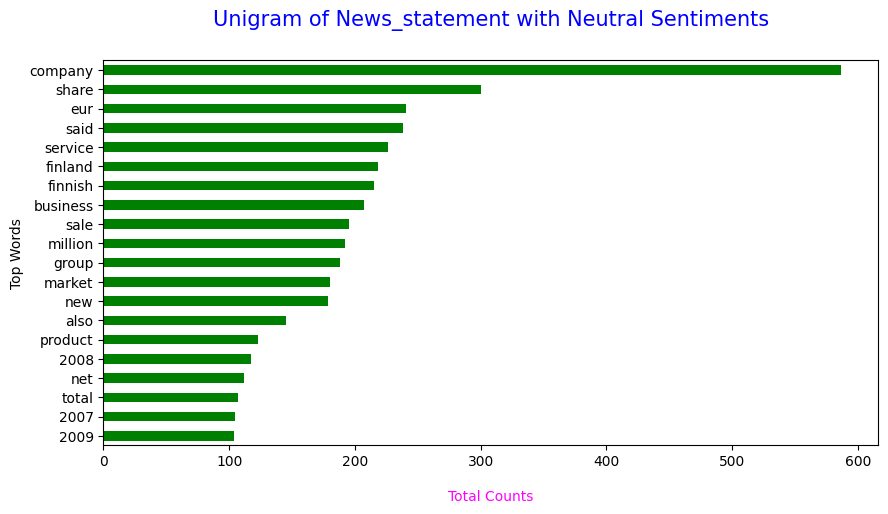

In [27]:
# Finding Unigram
words = Gram_Analysis(Neutral["News_statement"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green", figsize=(10, 5))
plt.title("Unigram of News_statement with Neutral Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words")

Text(0, 0.5, 'Top Words')

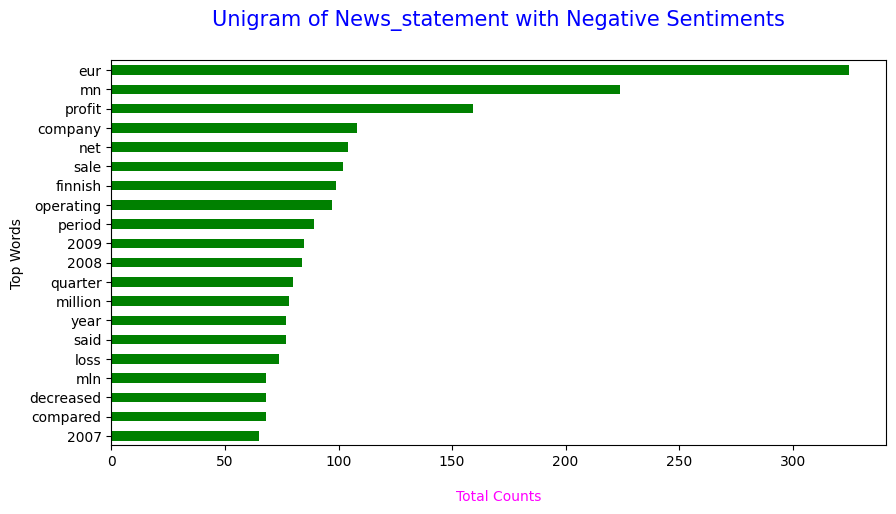

In [28]:
# Finding Unigram
words = Gram_Analysis(Negative["News_statement"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green", figsize=(10, 5))
plt.title("Unigram of News_statement with Negative Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words")

#### Bigram of Reviews Based On Sentiments

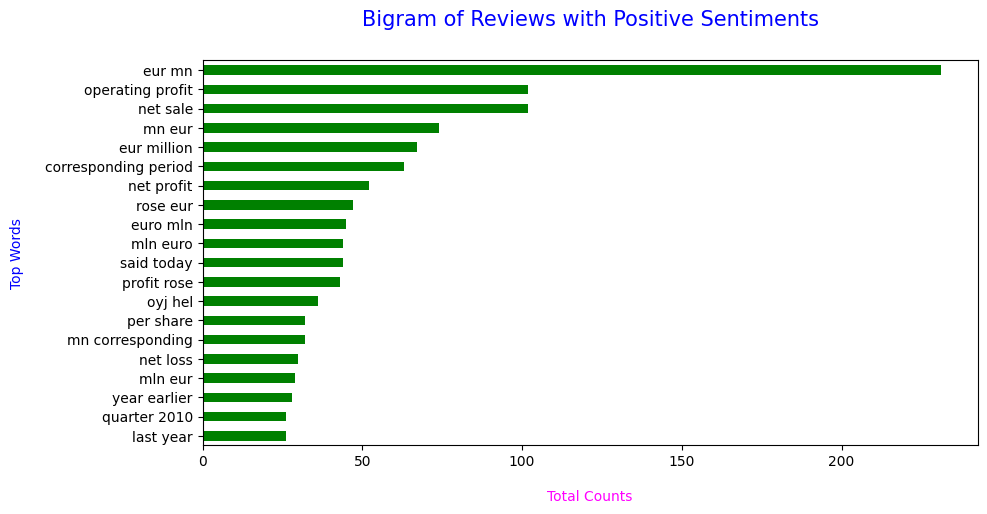

In [29]:
# Finding Bigram
words = Gram_Analysis(Positive["News_statement"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

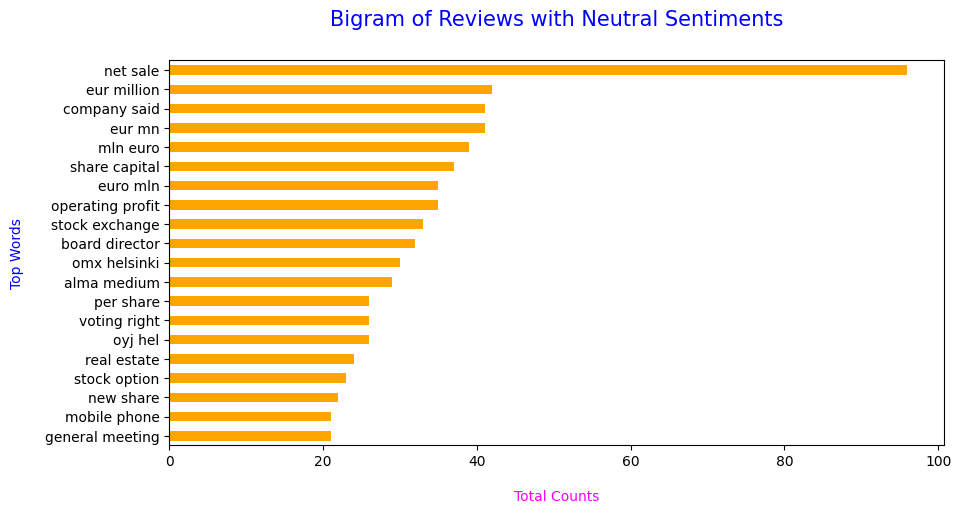

In [30]:
# Finding Bigram
words = Gram_Analysis(Neutral["News_statement"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

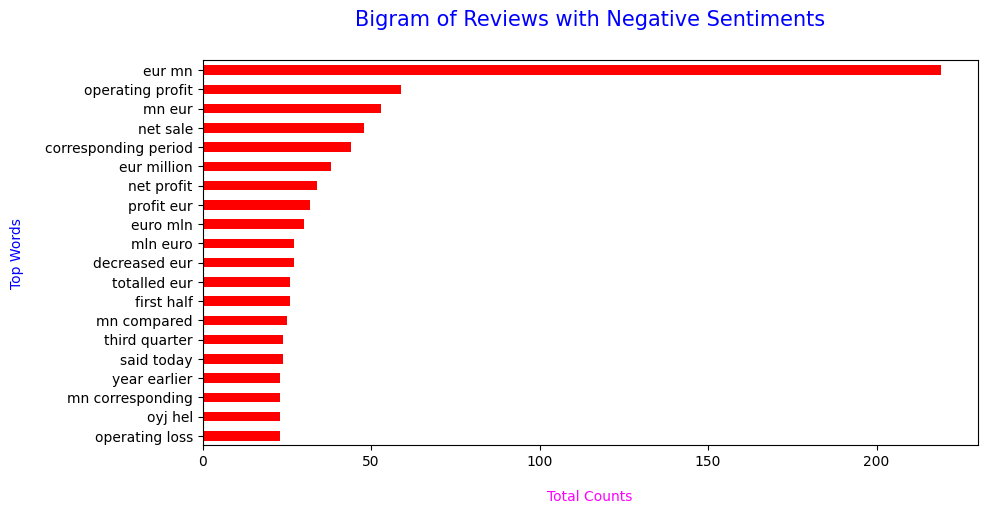

In [31]:
# Finding Bigram
words = Gram_Analysis(Negative["News_statement"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

#### Trigram of Reviews Based On Sentiments

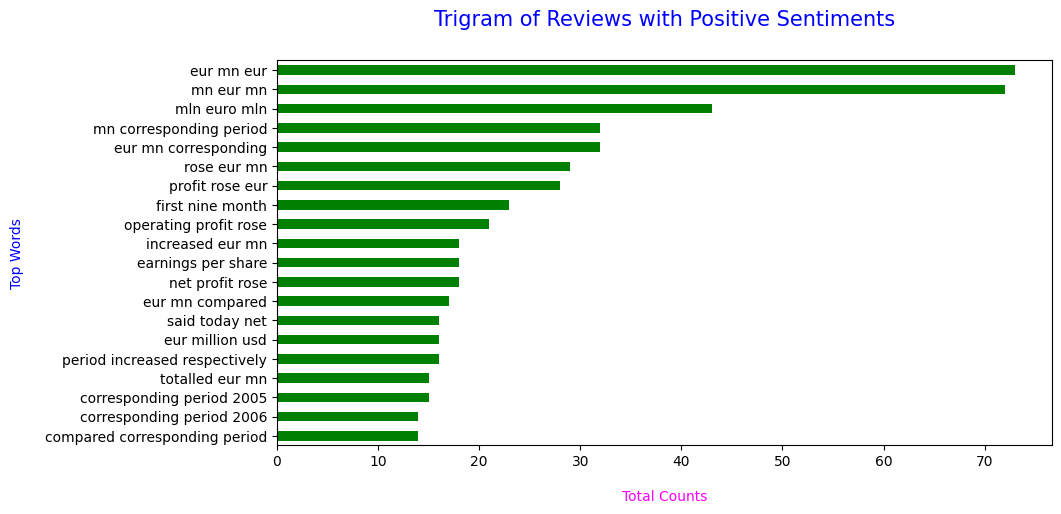

In [32]:
# Finding Trigram
words = Gram_Analysis(Positive["News_statement"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

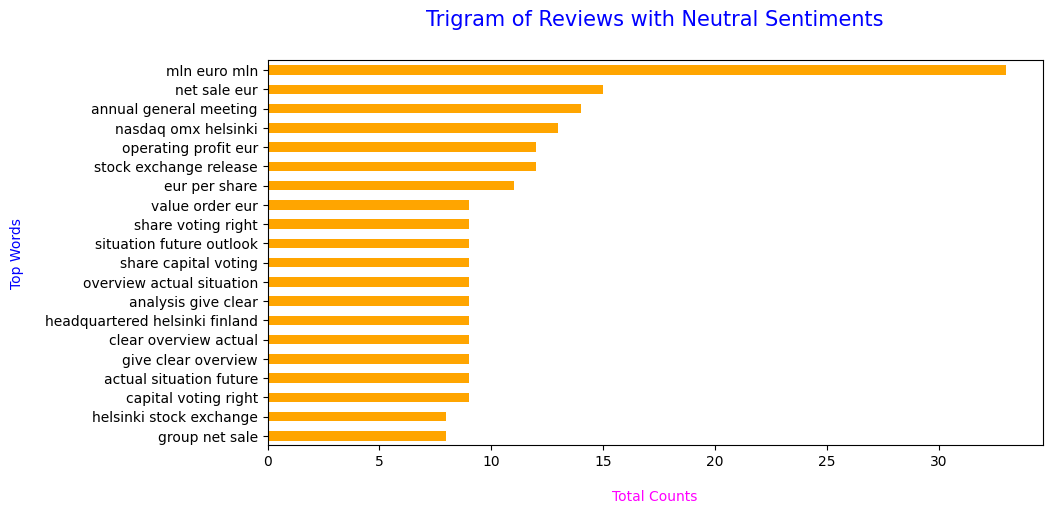

In [33]:
# Finding Trigram
words = Gram_Analysis(Neutral["News_statement"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

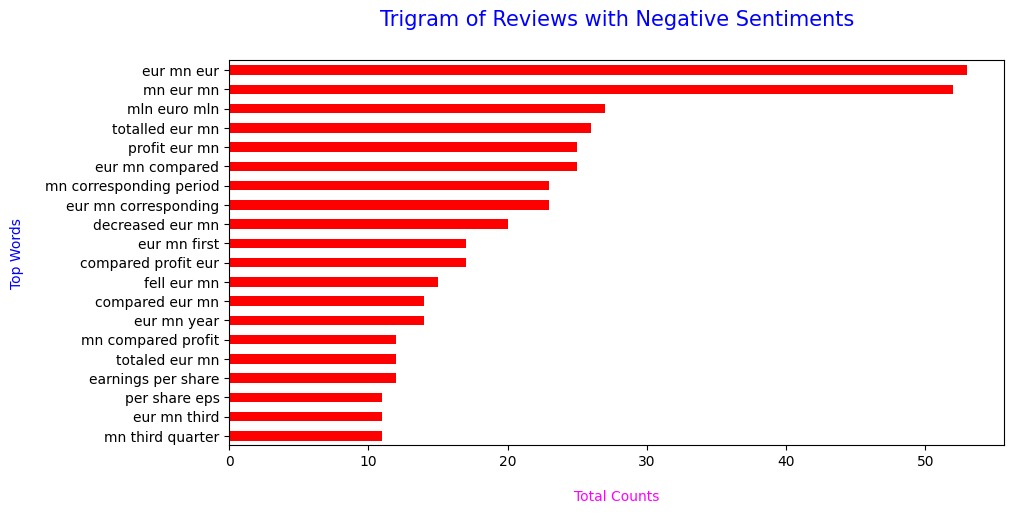

In [34]:
# Finding Trigram
words = Gram_Analysis(Negative["News_statement"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()


# Word Clouds

##### Word Cloud of Reviews with Positive Sentiments

In [35]:
# Assuming Positive["News_statement"] is a list or series of text data
from wordcloud import WordCloud
text_data = str(Positive["News_statement"])

# Generate the word cloud
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=Stopwords).generate(text_data)

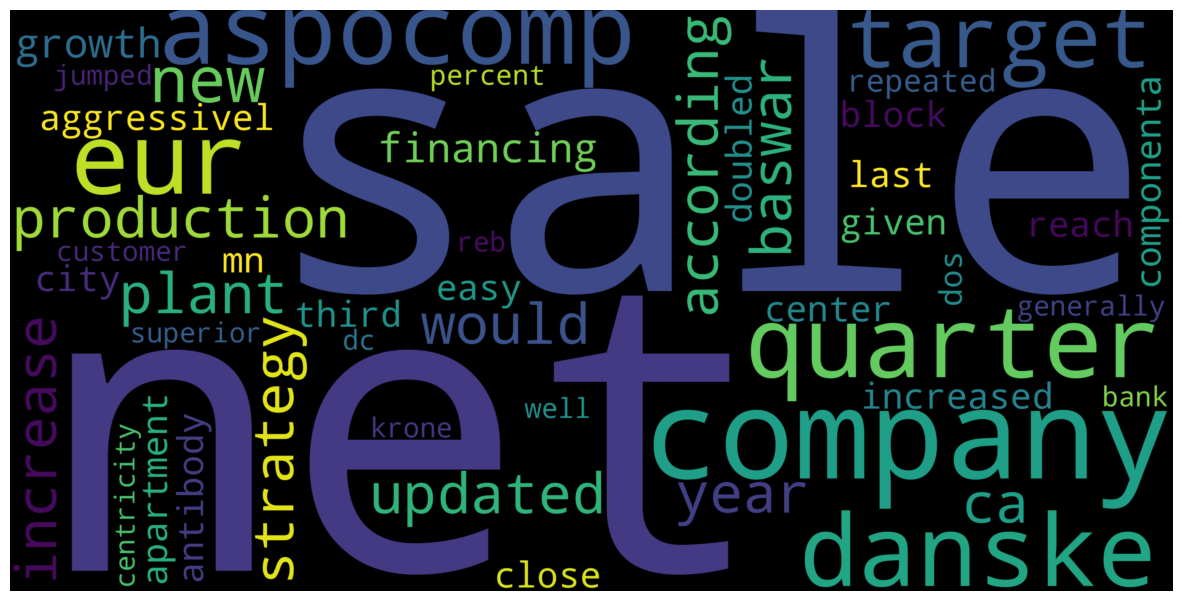

In [36]:
# wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["News_statement"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

##### Word Cloud of Reviews with Neutral Sentiments

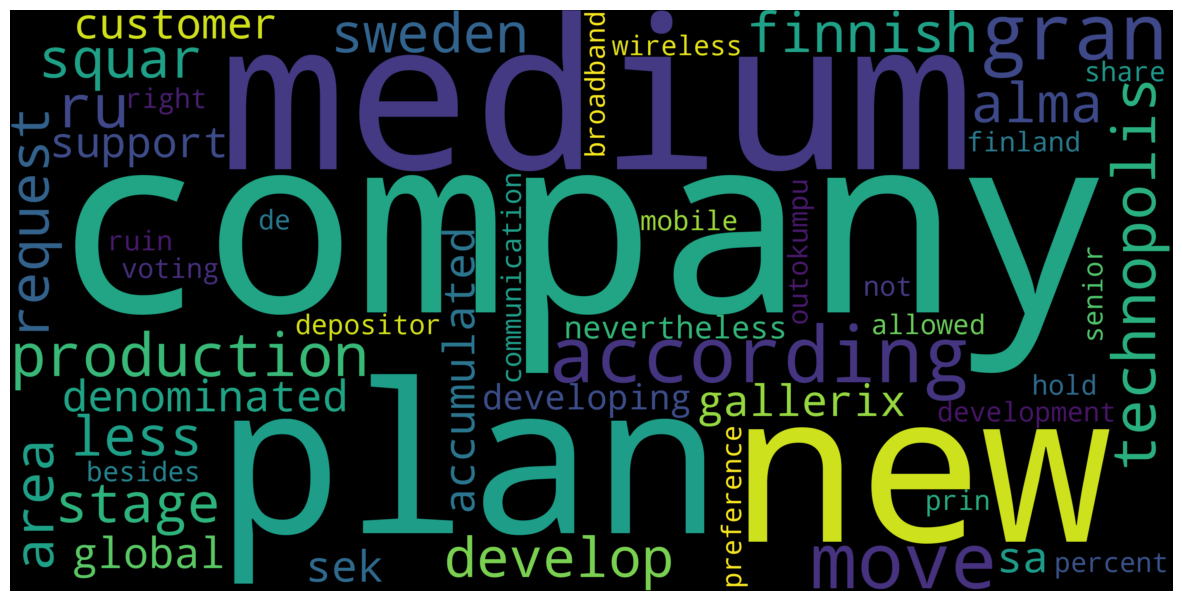

In [37]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["News_statement"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

##### Word Cloud of Reviews with Negative Sentiments

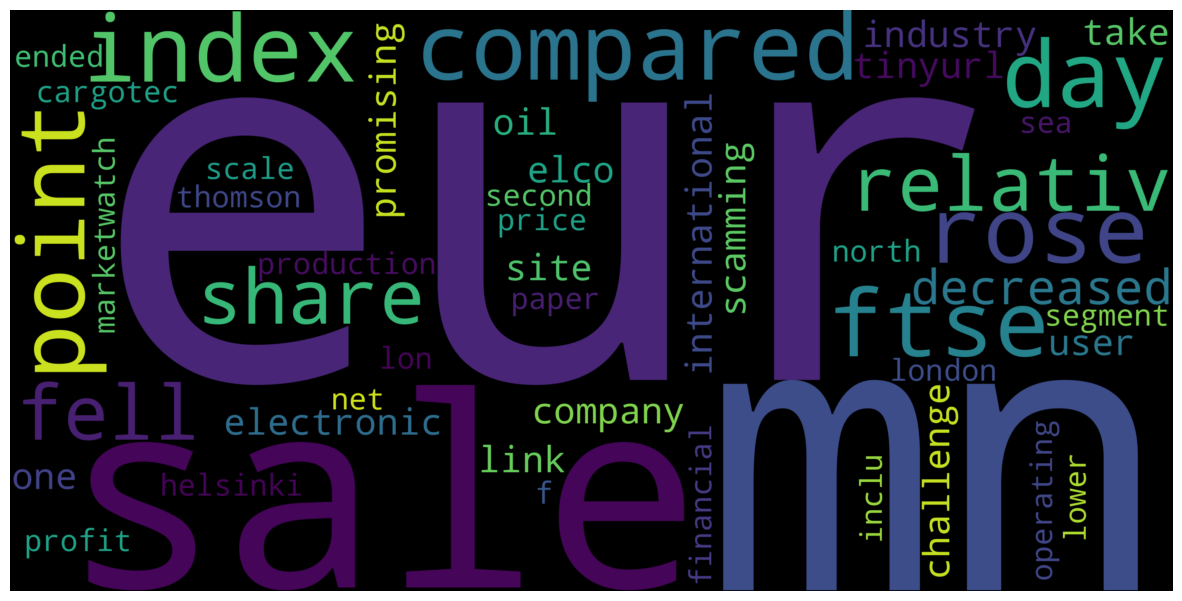

In [38]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["News_statement"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# TOP WORDS

In [39]:
positive_corpus = []
for msg in df[df['Sentiment'] == 2]['News_statement'].tolist():
    for word in msg.split():
        positive_corpus.append(word)

negative_corpus = []
for msg in df[df['Sentiment'] == 0]['News_statement'].tolist():
    for word in msg.split():
        negative_corpus.append(word)

neutral_corpus = []
for msg in df[df['Sentiment'] == 1]['News_statement'].tolist():
    for word in msg.split():
        neutral_corpus.append(word)

In [ ]:
print(len(positive_corpus))
print(len(negative_corpus))
print(len(neutral_corpus))

18082
7516
34089


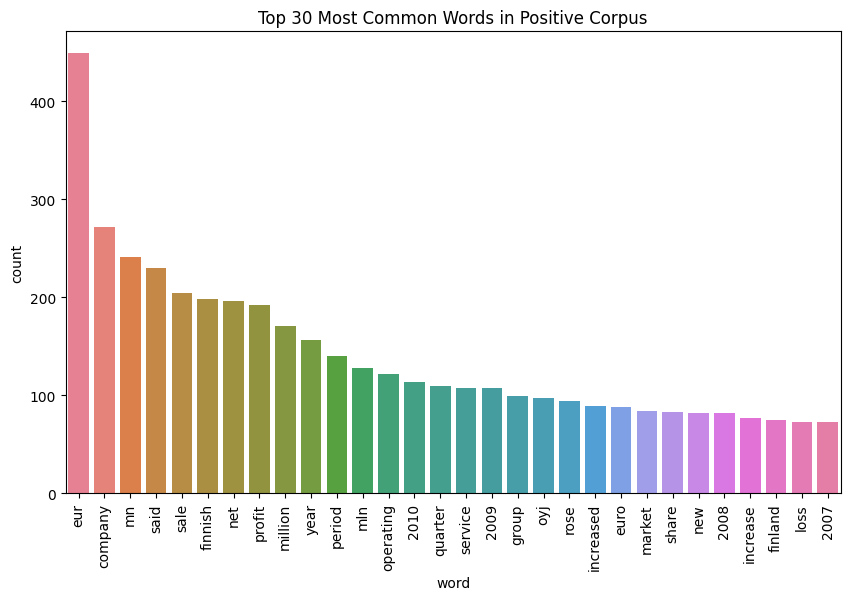

In [40]:
word_counts = Counter(positive_corpus)
most_common_words = word_counts.most_common(30)
df_most_common = pd.DataFrame(most_common_words, columns=['word', 'count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_most_common, palette='husl')
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Positive Corpus')
plt.show()

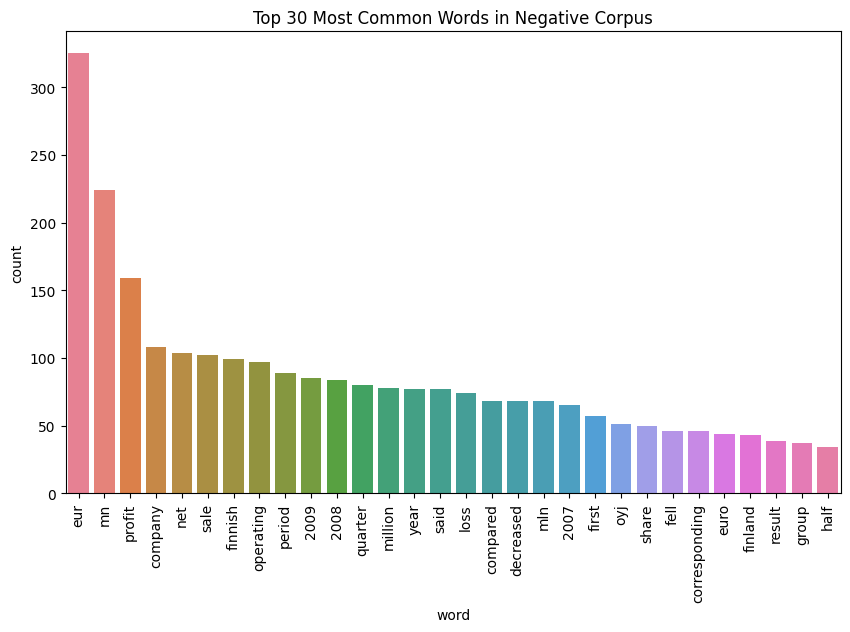

In [41]:
word_counts = Counter(negative_corpus)
most_common_words = word_counts.most_common(30)
df_most_common = pd.DataFrame(most_common_words, columns=['word', 'count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_most_common, palette='husl')
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Negative Corpus')
plt.show()

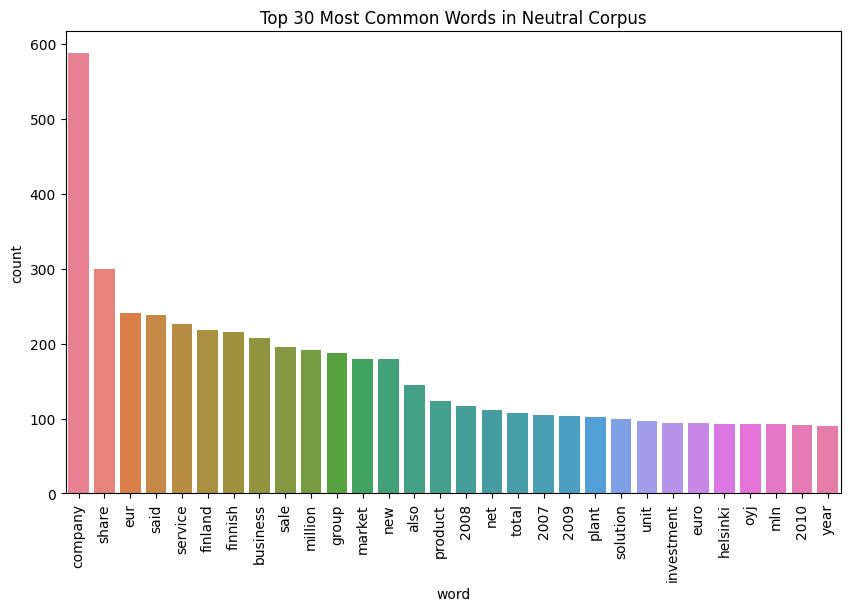

In [42]:
word_counts = Counter(neutral_corpus)
most_common_words = word_counts.most_common(30)
df_most_common = pd.DataFrame(most_common_words, columns=['word', 'count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_most_common, palette='husl')
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Neutral Corpus')
plt.show()

In [43]:
df

,Sentiment,News_statement,num_characters,num_words,num_sentences,polarity,length,word_counts
0,1,according gran company plan move production ru...,127,25,1,0.000000,75,10
1,1,technopolis plan develop stage area less squar...,190,31,1,-0.166667,133,17
2,0,international electronic industry company elco...,228,36,1,-0.160000,171,21
3,2,new production plant company would increase ca...,206,33,1,-0.064802,157,20
4,2,according company updated strategy year baswar...,203,41,1,0.000000,115,18
...,...,...,...,...,...,...,...,...
4841,0,london marketwatch share price ended lower lon...,144,26,1,-0.500000,115,17
4842,1,rinkuskiai beer sale fell per cent million lit...,148,30,1,0.000000,99,17
4843,0,operating profit fell eur mn eur mn 2007 inclu...,108,23,1,0.000000,74,14
4844,0,net sale paper segment decreased eur mn second...,226,44,1,0.040000,137,24


# TF-IDF

In [44]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['News_statement'])
df[['num_characters', 'num_words', 'polarity']] = df[['num_characters', 'num_words', 'polarity']].clip(lower=0)
other_features = df[['num_characters', 'num_words', 'polarity']].values
X = scipy.sparse.hstack([X_tfidf, other_features])
cosine_sim_matrix = cosine_similarity(X_tfidf)
df['average_similarity'] = cosine_sim_matrix.mean(axis=1)
other_features = df[['num_characters', 'num_words', 'polarity', 'average_similarity']].values
X = scipy.sparse.hstack([X_tfidf, other_features])
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(pd.Series(y_train_resampled).value_counts())

Sentiment
0    2310
1    2310
2    2310
Name: count, dtype: int64






##  Modelling

In [45]:
from xgboost import XGBClassifier

nb_classifier = MultinomialNB()
svm_classifier = SVC()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

classifiers = {
    "Naive Bayes": nb_classifier,
    "SVM": svm_classifier,
    "Random Forest": rf_classifier,
    "XGBoost": xgb_classifier,
}

for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print("=" * 60)

Naive Bayes Performance:
Accuracy: 0.40702479338842973
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       118
           1       1.00      0.11      0.20       563
           2       0.34      0.95      0.50       287

    accuracy                           0.41       968
   macro avg       0.65      0.52      0.42       968
weighted avg       0.76      0.41      0.33       968

SVM Performance:
Accuracy: 0.4090909090909091
              precision    recall  f1-score   support

           0       0.17      0.42      0.24       118
           1       0.66      0.41      0.51       563
           2       0.35      0.40      0.38       287

    accuracy                           0.41       968
   macro avg       0.39      0.41      0.37       968
weighted avg       0.51      0.41      0.44       968

Random Forest Performance:
Accuracy: 0.7355371900826446
              precision    recall  f1-score   support

           0       0.76   

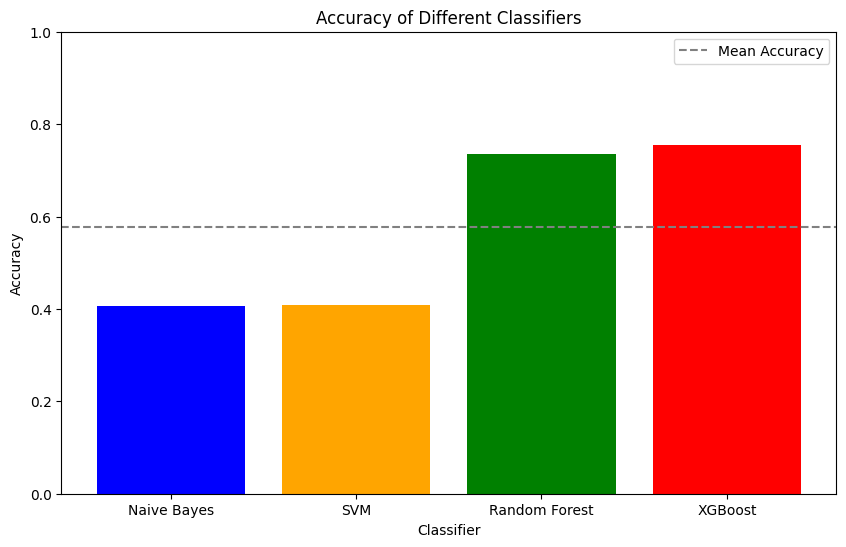

In [46]:
import numpy as np
accuracies = []

for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.bar(classifiers.keys(), accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.ylim(0, 1)
plt.axhline(y=np.mean(accuracies), color='gray', linestyle='--', label='Mean Accuracy')
plt.legend()
plt.show()

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        def clean(text):
            text = text.lower()
            tokens = nltk.word_tokenize(text)
            tokens = [lemmatizer.lemmatize(token) for token in tokens
                      if token.isalnum() and token not in stop_words]
            return " ".join(tokens)

        return X.apply(clean)  # assumes input is a pandas Series


In [48]:
class NumericFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X)
        df.columns = ['text']

        df['num_characters'] = df['text'].apply(len)
        df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
        df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

        return df[['num_characters', 'num_words', 'polarity']].clip(lower=0).values


In [49]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

# Pipeline for text cleaning and vectorization
tfidf_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2)))
])

# Pipeline for numeric feature extraction
numeric_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('numeric', NumericFeatureExtractor())
])

# Combine both feature sets
from sklearn.compose import ColumnTransformer

full_pipeline = FeatureUnion([
    ('tfidf_features', tfidf_pipeline),
    ('numeric_features', numeric_pipeline)
])

# Final model pipeline
model_pipeline = Pipeline([
    ('features', full_pipeline),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])


In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df[['News_statement']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply text cleaner before SMOTE (for numeric part only)
X_train_text = X_train['News_statement'].reset_index(drop=True)

# Fit model pipeline directly
model_pipeline.fit(X_train_text, y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf_features',
                                                 Pipeline(steps=[('cleaner',
                                                                  TextCleaner()),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('numeric_features',
                                                 Pipeline(steps=[('cleaner',
                                                                  TextCleaner()),
                                                                 ('numeric',
                                                                  NumericFeatureExtractor())]))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [51]:
import joblib

joblib.dump(model_pipeline, "sentiment_model_pipeline.pkl")


['sentiment_model_pipeline.pkl']

In [52]:
# Load pipeline
loaded_model = joblib.load("sentiment_model_pipeline.pkl")

# Predict
headline = "Major corporation files for bankruptcy, thousands lose jobs"
prediction = loaded_model.predict(pd.Series([headline]))
print("Predicted Sentiment:", prediction[0])


Predicted Sentiment: 1
